In [1]:
import jax.numpy as jnp
import jax
from jax.experimental.host_callback import id_print


In [2]:
import matplotlib.pyplot as plt
from jax.lax import scan
from jax import grad, jit, vmap
import jax.random as random
from functools import partial


In [3]:
import scipy

import seaborn as sns
rng = random.PRNGKey(2022)


sns.set_style("darkgrid")
cm = sns.color_palette("mako_r", as_cmap=True)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
import torch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device: ",device)

Device:  cuda


In [5]:
def sample_sphere(J):
    """
    2 dimensional sample
    
    N_samples: Number of samples
    Returns a (N_samples, 2) array of samples
    """
    alphas = jnp.linspace(0, 2*jnp.pi * (1 - 1/J), J)
    xs = jnp.cos(alphas)
    ys = jnp.sin(alphas)
    mf = jnp.stack([xs, ys], axis=1)
    return mf

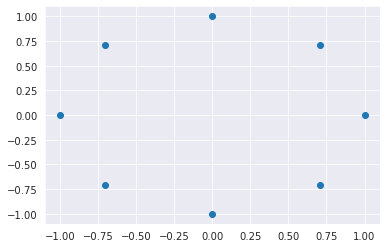

In [6]:
J = 8
mf = sample_sphere(J)
plt.scatter(mf[:, 0], mf[:, 1])

In [7]:
beta_min = 0.001
beta_max = 3

def beta_t(t):
    """
    t: time (number)
    returns beta_t as explained above
    """
    return beta_min + t*(beta_max - beta_min)

def alpha_t(t):
    """
    t: time (number)
    returns alpha_t as explained above
    """
    return t*beta_min + 0.5 * t**2 * (beta_max - beta_min)

def drift(x, t):
    """
    x: location of J particles in N dimensions, shape (J, N)
    t: time (number)
    returns the drift of a time-changed OU-process for each batch member, shape (J, N)
    """
    return -0.5*beta_t(t)*x

def dispersion(t):
    """
    t: time (number)
    returns the dispersion
    """
    return jnp.sqrt(beta_t(t))

def mean_factor(t):
    """
    t: time (number)
    returns m_t as above
    """
    return jnp.exp(-0.5 * alpha_t(t))

def var(t):
    """
    t: time (number)
    returns v_t as above
    """
    return 1 - jnp.exp(-alpha_t(t))

In [8]:
from jax.scipy.special import logsumexp

def log_hat_pt(x, t):
    """
    x: One location in R^n
    t: time (number)
    returns the log density log \hat{p}_t(x) as described above
    
    """
    N = mf.shape[0]
    means = mf * mean_factor(t)
    v = var(t)
    potentials = jnp.sum(-(x - means)**2 / (2 * v), axis=1)
    # this is equivalent to
    # return jnp.log(1/N * jnp.sum(jnp.exp(potentials)))
    # but is numerically more stable
    return logsumexp(potentials, axis=0, b=1/N)

nabla_log_hat_pt = jit(vmap(grad(log_hat_pt), in_axes=(0, 0), out_axes=(0)))

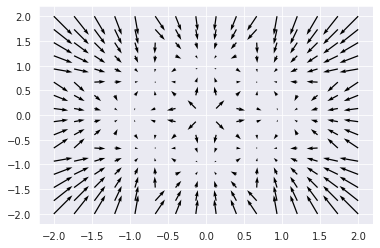

In [9]:
def plot_score(score, t, area_min=-1, area_max=1):
    #this helper function is here so that we can jit it.
    #We can not jit the whole function since plt.quiver cannot
    #be jitted
    @partial(jit, static_argnums=[0,])
    def helper(score, t, area_min, area_max):
        x = jnp.linspace(area_min, area_max, 16)
        x, y = jnp.meshgrid(x, x)
        grid = jnp.stack([x.flatten(), y.flatten()], axis=1)
        t = jnp.ones((grid.shape[0], 1)) * t
        scores = score(grid, t)
        return grid, scores
    grid, scores = helper(score, t, area_min, area_max)
    plt.quiver(grid[:, 0], grid[:, 1], scores[:, 0], scores[:, 1])

plot_score(nabla_log_hat_pt, 0.001, -2, 2)

In [10]:
R = 1000
train_ts = jnp.arange(1, R)/(R-1)

#we jit the function, but we have to mark some of the arguments as static,
#which means the function is recompiled every time these arguments are changed,
#since they are directly compiled into the binary code. This is necessary
#since jitted-functions cannot have functions as arguments. But it also 
#no problem since these arguments will never/rarely change in our case,
#therefore not triggering re-compilation.
@partial(jit, static_argnums=[1,2,3,4,5])
def reverse_sde(rng, N, n_samples, forward_drift, dispersion, score, ts=train_ts):
    """
    rng: random number generator (JAX rng)
    N: dimension in which the reverse SDE runs
    N_initial: How many samples from the initial distribution N(0, I), number
    forward_drift: drift function of the forward SDE (we implemented it above)
    disperion: dispersion function of the forward SDE (we implemented it above)
    score: The score function to use as additional drift in the reverse SDE
    ts: a discretization {t_i} of [0, T], shape 1d-array
    """
    def f(carry, params):
        t, dt = params
        x, rng = carry
        rng, step_rng = jax.random.split(rng)
        disp = dispersion(1-t)
        t = jnp.ones((x.shape[0], 1)) * t
        drift = -forward_drift(x, 1-t) + disp**2 * score(x, 1-t)
        noise = random.normal(step_rng, x.shape)

        x = x + dt * drift + jnp.sqrt(dt)*disp*noise
        return (x, rng), ()
    
    rng, step_rng = random.split(rng)
    initial = random.normal(step_rng, (n_samples, N))
    dts = ts[1:] - ts[:-1]
    params = jnp.stack([ts[:-1], dts], axis=1)
    #scan is jax version of a for-loop (can be compiled to high-performance code cheaply)
    (x, _), _ = scan(f, (initial, rng), params)
    return x

In [11]:
def plot_heatmap(positions, area_min=-2, area_max=2):
    """
    positions: locations of all particles in R^2, array (J, 2)
    area_min: lowest x and y coordinate
    area_max: highest x and y coordinate
    
    will plot a heatmap of all particles in the area [area_min, area_max] x [area_min, area_max]
    """
    def small_kernel(z, area_min, area_max):
        a = jnp.linspace(area_min, area_max, 512)
        x, y = jnp.meshgrid(a, a)
        dist = (x - z[0])**2 + (y - z[1])**2
        hm = jnp.exp(-350*dist)
        return hm

    #again we try to jit most of the code, but use the helper functions
    #since we cannot jit all of it because of the plt functions
    @jit
    def produce_heatmap(positions, area_min, area_max):
        return jnp.sum(vmap(small_kernel, in_axes=(0, None, None))(positions, area_min, area_max), axis=0)

    hm = produce_heatmap(positions, area_min, area_max) #np.sum(vmap(small_kernel)(to_plot), axis=0)
    extent = [area_min, area_max, area_max, area_min]
    plt.imshow(hm, cmap=cm, interpolation='nearest', extent=extent)
    ax = plt.gca()
    ax.invert_yaxis()


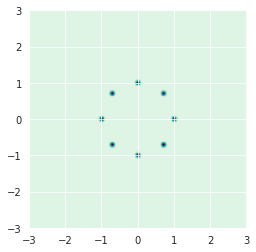

In [12]:


rng, step_rng = random.split(rng)
samples = reverse_sde(step_rng, 2, 5000, drift, dispersion, nabla_log_hat_pt)
plot_heatmap(samples[:, [0,1]], -3, 3)



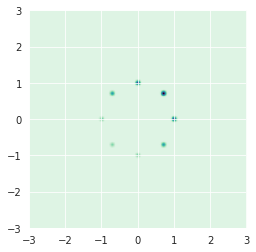

In [13]:
#bounded perturbation of score
perturbed_score = lambda x, t: nabla_log_hat_pt(x, t) + 0.5
rng, step_rng = random.split(rng)
samples = reverse_sde(step_rng, 2, 5000, drift, dispersion, perturbed_score)
plot_heatmap(samples[:, [0,1]], -3, 3)

In [14]:

import flax.linen as nn

class ApproximateScore(nn.Module):
    """A simple model with multiple fully connected layers and some fourier features for the time variable."""

    @nn.compact
    def __call__(self, x, t):
        in_size = x.shape[1]
        n_hidden = 256
        act = nn.relu
        t = jnp.concatenate([t - 0.5, jnp.cos(2*jnp.pi*t), jnp.sin(2*jnp.pi*t), -jnp.cos(4*jnp.pi*t)],axis=1)
        x = jnp.concatenate([x, t],axis=1)
        x = nn.Dense(n_hidden)(x)
        x = nn.relu(x)
        x = nn.Dense(n_hidden)(x)
        x = nn.relu(x)
        x = nn.Dense(n_hidden)(x)
        x = nn.relu(x)
        x = nn.Dense(in_size)(x)
        return x

In [15]:


import optax

batch_size = 16
#some dummy input data. Flax is able to infer all the dimensions of the weights
#if we supply if with the kind of input data it has to expect
x = jnp.zeros(2*batch_size).reshape((batch_size, 2))
time = jnp.ones((batch_size, 1))
#initialize the model weights
score_model = ApproximateScore()
params = score_model.init(rng, x, time)

print(params)
#Initialize the optimizer
optimizer = optax.adam(1e-3)
opt_state = optimizer.init(params)
print(opt_state)


FrozenDict({
    params: {
        Dense_0: {
            kernel: Array([[ 0.75446385,  0.02738776,  0.83832204, ..., -0.5114502 ,
                    -0.01584598, -0.44878474],
                   [ 0.27869081,  0.6138079 ,  0.07207032, ...,  0.11369416,
                     0.6503468 ,  0.04189492],
                   [ 0.02884469,  0.09793361,  0.16537464, ..., -0.18563265,
                    -0.04837719,  0.40506124],
                   [ 0.24449737, -0.38900742,  0.22557199, ..., -0.09531334,
                    -0.66426027,  0.3948076 ],
                   [ 0.21288244,  0.35436124,  0.59794486, ..., -0.60505503,
                     0.10763837,  0.258428  ],
                   [ 0.48968446,  0.5991973 , -0.31325194, ..., -0.01031079,
                     0.27804208, -0.653782  ]], dtype=float32),
            bias: Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
                   0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
     

In [17]:
def loss_fn(params, model, rng, batch):
    """
    params: the current weights of the model
    model: the score function
    rng: random number generator from jax
    batch: a batch of samples from the training data, representing samples from \mu_text{data}, shape (J, N)
    
    returns an random (MC) approximation to the loss \bar{L} explained above
    """
    rng, step_rng = random.split(rng)
    N_batch = batch.shape[0]
    t = random.randint(step_rng, (N_batch,1), 1, R)/(R-1)
    mean_coeff = mean_factor(t)
    #is it right to have the square root here for the loss?
    vs = var(t)
    stds = jnp.sqrt(vs)
    rng, step_rng = random.split(rng)
    noise = random.normal(step_rng, batch.shape)
    xt = batch * mean_coeff + noise * stds
    output = score_model.apply(params, xt, t)
    loss = jnp.mean((noise + output*stds)**2)
    return loss

@partial(jit, static_argnums=[4])
def update_step(params, rng, batch, opt_state, model):
    """
    params: the current weights of the model
    rng: random number generator from jax
    batch: a batch of samples from the training data, representing samples from \mu_text{data}, shape (J, N)
    opt_state: the internal state of the optimizer
    model: the score function

    takes the gradient of the loss function and updates the model weights (params) using it. Returns
    the value of the loss function (for metrics), the new params and the new optimizer state
    """
    val, grads = jax.value_and_grad(loss_fn)(params, model, rng, batch)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return val, params, opt_state

In [19]:
N_epochs = 30_000
train_size = mf.shape[0]
batch_size = train_size
# batch_size = 5
steps_per_epoch = train_size // batch_size
losses = []
for k in range(N_epochs):
    rng, step_rng = random.split(rng)
    perms = jax.random.permutation(step_rng, train_size)
    perms = perms[:steps_per_epoch * batch_size]  # skip incomplete batch
    perms = perms.reshape((steps_per_epoch, batch_size))
    for perm in perms:
        batch = mf[perm, :]
        rng, step_rng = random.split(rng)
        loss, params, opt_state = update_step(params, step_rng, batch, opt_state, score_model)
        losses.append(loss)
    if (k+1) % 1000 == 0:
        mean_loss = jnp.mean(jnp.array(losses))
        print("Epoch %d \t, Loss %f " % (k+1, mean_loss))
        losses = []

Epoch 1000 	, Loss 0.548104 
Epoch 2000 	, Loss 0.504495 
Epoch 3000 	, Loss 0.485810 
Epoch 4000 	, Loss 0.458083 
Epoch 5000 	, Loss 0.450009 
Epoch 6000 	, Loss 0.465231 
Epoch 7000 	, Loss 0.436885 
Epoch 8000 	, Loss 0.435251 
Epoch 9000 	, Loss 0.437562 
Epoch 10000 	, Loss 0.432903 
Epoch 11000 	, Loss 0.422481 
Epoch 12000 	, Loss 0.419387 
Epoch 13000 	, Loss 0.402738 
Epoch 14000 	, Loss 0.403351 
Epoch 15000 	, Loss 0.398076 
Epoch 16000 	, Loss 0.391914 
Epoch 17000 	, Loss 0.384234 
Epoch 18000 	, Loss 0.386658 
Epoch 19000 	, Loss 0.397397 
Epoch 20000 	, Loss 0.370183 
Epoch 21000 	, Loss 0.372591 
Epoch 22000 	, Loss 0.380594 
Epoch 23000 	, Loss 0.380595 
Epoch 24000 	, Loss 0.379756 
Epoch 25000 	, Loss 0.374149 
Epoch 26000 	, Loss 0.380875 
Epoch 27000 	, Loss 0.374063 
Epoch 28000 	, Loss 0.371272 
Epoch 29000 	, Loss 0.371641 
Epoch 30000 	, Loss 0.376946 


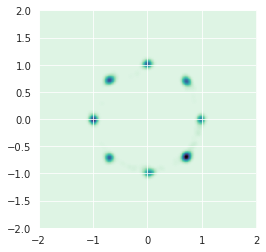

In [23]:
tr_score = lambda x, t: score_model.apply(params, x, t)
rng, step_rng = random.split(rng)
samples = reverse_sde(step_rng, 2, 1000, drift, dispersion, tr_score)
plot_heatmap(samples)

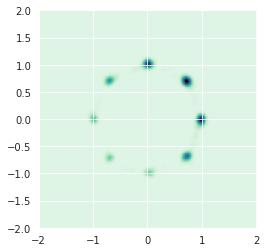

In [22]:
pert_score = lambda x, t: score_model.apply(params, x, t)+0.5
rng, step_rng = random.split(rng)
samples = reverse_sde(step_rng, 2, 1000, drift, dispersion, pert_score)
plot_heatmap(samples)

# Haiku trail

In [140]:
class ApproximateScorehk(hk.Module):
    """A simple model with multiple fully connected layers and some fourier features for the time variable."""

    def __init__(self, n_hidden):
        super().__init__()
        self.n_hidden = n_hidden

    def __call__(self, x, t):
        in_size = x.shape[1]
        t = jnp.concatenate([t - 0.5, jnp.cos(2 * jnp.pi * t), jnp.sin(2 * jnp.pi * t), -jnp.cos(4 * jnp.pi * t)], axis=1)
        x = jnp.concatenate([x, t], axis=1)
        x = hk.Linear(self.n_hidden)(x)
        x = jax.nn.relu(x)
        x = hk.Linear(self.n_hidden)(x)
        x = jax.nn.relu(x)
        x = hk.Linear(self.n_hidden)(x)
        x = jax.nn.relu(x)
        x = hk.Linear(in_size)(x)
        return x

def forward_fn(x,t):
    model = ApproximateScorehk(10)
    return model(x,t)
forward = hk.transform(forward_fn)
print(forward)

Transformed(init=<function without_state.<locals>.init_fn at 0x7efd44145ee0>, apply=<function without_state.<locals>.apply_fn at 0x7efd2073aee0>)


In [141]:
@jax.jit
def loss_fn(params, rng, batch):
    """
    params: the current weights of the model
    model: the score function
    rng: random number generator from jax
    batch: a batch of samples from the training data, representing samples from \mu_text{data}, shape (J, N)
    
    returns an random (MC) approximation to the loss \bar{L} explained above
    """
    rng, step_rng = random.split(rng)
    N_batch = batch.shape[0]
    t = random.randint(step_rng, (N_batch,1), 1, R)/(R-1)
    mean_coeff = mean_factor(t)
    #is it right to have the square root here for the loss?
    vs = var(t)
    stds = jnp.sqrt(vs)
    rng, step_rng = random.split(rng)
    noise = random.normal(step_rng, batch.shape)
    xt = batch * mean_coeff + noise * stds
    #output = score_model.apply(params, xt, t)
    output = forward.apply(params, rng, xt, t)
    loss = jnp.mean((noise + output*stds)**2)
    return loss
@jax.jit
def update_step(params, rng, batch, opt_state):
    """
    params: the current weights of the model
    rng: random number generator from jax
    batch: a batch of samples from the training data, representing samples from \mu_text{data}, shape (J, N)
    opt_state: the internal state of the optimizer
    model: the score function

    takes the gradient of the loss function and updates the model weights (params) using it. Returns
    the value of the loss function (for metrics), the new params and the new optimizer state
    """
    val, grads = jax.value_and_grad(loss_fn)(params, rng, batch)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return val, params, opt_state

In [142]:
x = jnp.zeros(2*batch_size).reshape((batch_size, 2))
time = jnp.ones((batch_size, 1))
key = hk.PRNGSequence(24)
params = forward.init(next(key), x, time)
print(params)
optimizer = optax.adam(1e-3)
opt_state = optimizer.init(params)
print(opt_state)

{'approximate_scorehk/linear': {'w': Array([[ 0.20295727,  0.14103921, -0.37843397,  0.4119156 , -0.19954711,
        -0.3166667 ,  0.46788663, -0.2941004 ,  0.2200713 ,  0.12460878],
       [ 0.30675542,  0.0598558 ,  0.24589376,  0.32137033,  0.18032913,
         0.3001914 ,  0.11868861,  0.09899616, -0.5694401 ,  0.08619159],
       [-0.5063345 , -0.04274466, -0.01118238,  0.25310206,  0.12606981,
        -0.03824007,  0.21095315, -0.27336812, -0.41597006, -0.20747195],
       [ 0.3185439 ,  0.49399167,  0.25306666, -0.02680708,  0.2585957 ,
        -0.60671514,  0.33713058,  0.22252578,  0.07680173, -0.6044003 ],
       [-0.0816277 , -0.146054  , -0.19088769,  0.5506077 ,  0.49740666,
         0.4007659 , -0.54977554, -0.22154324,  0.17766349, -0.4591902 ],
       [ 0.3735265 ,  0.03654413, -0.11970869, -0.09540194, -0.18401204,
         0.24363033,  0.12215336,  0.16740221,  0.42802444,  0.5332137 ]],      dtype=float32), 'b': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=

In [1]:

    def marginal_prob(self,x,t,sigma=25):
        if self.sde_type == 'VESDE':
            mean = x
            std = self.sigma_0*(self.sigma_1/self.sigma_0)**t
            # std = self.sigma_1*t
            std = tf.reshape(std,self.shape)
        else:
            log_mean_coeff = -0.25 * t ** 2 * (self.beta_1 - self.beta_0) - 0.5 * t * self.beta_0
            log_mean_coeff = tf.reshape(log_mean_coeff,self.shape)
            mean = tf.where(tf.abs(log_mean_coeff) <= 1e-3, (1 + log_mean_coeff), tf.exp(log_mean_coeff))*x
            #mean = tf.exp(log_mean_coeff)*x
            if self.sde_type == 'VPSDE':
                # std = tf.math.sqrt(1 - tf.exp(2. * log_mean_coeff))
                std = tf.where(tf.abs(log_mean_coeff) <= 1e-3, tf.math.sqrt(-2. * log_mean_coeff),
                               tf.math.sqrt(1 - tf.exp(2. * log_mean_coeff)))
            elif self.sde_type == 'subVPSDE':
                #std = 1 - tf.exp(2. * log_mean_coeff)
                std = tf.where(tf.abs(log_mean_coeff) <= 1e-3, -2. * log_mean_coeff,
                               1 - tf.exp(2. * log_mean_coeff))
        return mean, std


    def prior_sde(self,dimensions):
        if self.sde_type == 'VESDE':
            return tf.random.normal(dimensions)*self.sigma_1
        else:
            return tf.random.normal(dimensions)

    def sde(self, x, t):
        if self.sde_type == 'VESDE':
            drift = tf.zeros_like(x,dtype=tf.float32)
            sigma = self.sigma_0 * (self.sigma_1 / self.sigma_0) ** t
            diffusion = sigma * tf.math.sqrt(2 * (tf.math.log(self.sigma_1) - tf.math.log(self.sigma_0)))
            diffusion =tf.reshape(diffusion,self.shape)
        else:
            beta_t = self.beta_0 + t * (self.beta_1 - self.beta_0)
            beta_t = tf.reshape(beta_t,self.shape)
            drift = -0.5 * beta_t* x
            if self.sde_type == 'VPSDE':            
                diffusion = tf.math.sqrt(beta_t)
            elif self.sde_type == 'subVPSDE':
                exponent = -2 * self.beta_0 * t - (self.beta_1 - self.beta_0) * t ** 2
                discount = 1. - tf.exp(exponent)
                discount = tf.where(tf.abs(exponent) <= 1e-3, -exponent, discount)                
                discount = tf.reshape(discount,self.shape)
                diffusion = tf.math.sqrt(beta_t * discount)
        return drift, diffusion

In [ ]:


#@title Sampler code
num_steps = 500#@param {'type':'integer'}
def Euler_Maruyama_sampler(score_model, 
              marginal_prob_std,
              diffusion_coeff, 
              batch_size=64, 
              x_shape=(1, 28, 28),
              num_steps=num_steps, 
              device='cuda', 
              eps=1e-3, y=None):
    """Generate samples from score-based models with the Euler-Maruyama solver.

    Args:
        score_model: A PyTorch model that represents the time-dependent score-based model.
        marginal_prob_std: A function that gives the standard deviation of
          the perturbation kernel.
        diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
        batch_size: The number of samplers to generate by calling this function once.
        num_steps: The number of sampling steps. 
          Equivalent to the number of discretized time steps.
        device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
        eps: The smallest time step for numerical stability.

      Returns:
        Samples.    
    """
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, *x_shape, device=device) \
    * marginal_prob_std(t)[:, None, None, None]
    time_steps = torch.linspace(1., eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    with torch.no_grad():
    for time_step in tqdm(time_steps):      
        batch_time_step = torch.ones(batch_size, device=device) * time_step
        g = diffusion_coeff(batch_time_step)
        mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step, y=y) * step_size
        x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)      
    # Do not include any noise in the last sampling step.
    return mean_x
     
